* PyConJP2016
  * http://sssslide.com/speakerdeck.com/sinhrks/pyconjp-2016-pandas-niyoru-shi-xi-lie-detachu-li
* PyCon2017
  * https://github.com/AileenNielsen/TimeSeriesAnalysisWithPython
  * https://www.youtube.com/watch?v=zmfe2RaX-14
* https://logics-of-blue.com/python-time-series-analysis/
* https://logics-of-blue.com/wp-content/uploads/2017/05/python-time-series-analysis-notebook.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pylab
import matplotlib.pyplot as plt
import seaborn
import datetime
import glob
import numpy as np
import pandas as pd
import statsmodels.api as sm
seaborn.set(style='ticks', palette='tab10', context='talk')
font_files = matplotlib.font_manager.findSystemFonts(fontpaths='/System/Library/Assets/com_apple_MobileAsset_Font4/')
font_list = matplotlib.font_manager.createFontList(font_files)
matplotlib.font_manager.fontManager.ttflist.extend(font_list)
font = {'family' : 'Osaka'}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = [10.0, 8.0]

/Users/keiji/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 花粉の飛散データ

In [2]:
df = pd.read_csv("data/Data.csv")

In [3]:
df[20:25]

,測定局コード,アメダス測定局コード,年月日,時,測定局名,測定局種別,都道府県コード,都道府県名,市区町村コード,市区町村名,花粉飛散数[個/m3],風向,風速[m/s],気温[℃],降水量[mm],レーダー降水量[mm]
20,50810100,40201.0,20180201,21,水戸石川一般環境大気測定局,1,8,茨城県,8201,水戸市,0,1.0,5.0,2.2,0.0,0
21,50810100,40201.0,20180201,22,水戸石川一般環境大気測定局,1,8,茨城県,8201,水戸市,0,16.0,2.0,1.5,0.0,0
22,50810100,40201.0,20180201,23,水戸石川一般環境大気測定局,1,8,茨城県,8201,水戸市,4,15.0,3.0,0.5,0.0,1
23,50810100,40201.0,20180201,24,水戸石川一般環境大気測定局,1,8,茨城県,8201,水戸市,0,16.0,3.0,0.4,0.0,0
24,50810100,40201.0,20180202,1,水戸石川一般環境大気測定局,1,8,茨城県,8201,水戸市,4,16.0,3.0,0.3,0.0,0


まさかの2月1日24時という表記があるので、2月2日0時になるようにdate_parserを調整。

In [4]:
df = pd.read_csv("data/Data.csv", parse_dates={'date':[2,3]}, index_col='date', date_parser=lambda x,y: pd.datetime.strptime(x+str(int(y)-1),'%Y%m%d%H') + datetime.timedelta(hours=1))

In [5]:
df.head()

,測定局コード,アメダス測定局コード,測定局名,測定局種別,都道府県コード,都道府県名,市区町村コード,市区町村名,花粉飛散数[個/m3],風向,風速[m/s],気温[℃],降水量[mm],レーダー降水量[mm]
date,,,,,,,,,,,,,,
2018-02-01 01:00:00,50810100,40201.0,水戸石川一般環境大気測定局,1,8,茨城県,8201,水戸市,12,15.0,2.0,-0.1,0.0,0
2018-02-01 02:00:00,50810100,40201.0,水戸石川一般環境大気測定局,1,8,茨城県,8201,水戸市,0,15.0,2.0,-0.2,0.0,0
2018-02-01 03:00:00,50810100,40201.0,水戸石川一般環境大気測定局,1,8,茨城県,8201,水戸市,0,1.0,1.0,-0.3,0.0,0
2018-02-01 04:00:00,50810100,40201.0,水戸石川一般環境大気測定局,1,8,茨城県,8201,水戸市,0,14.0,1.0,0.4,0.0,0
2018-02-01 05:00:00,50810100,40201.0,水戸石川一般環境大気測定局,1,8,茨城県,8201,水戸市,4,16.0,1.0,-0.8,0.0,0


In [6]:
df.tail()

,測定局コード,アメダス測定局コード,測定局名,測定局種別,都道府県コード,都道府県名,市区町村コード,市区町村名,花粉飛散数[個/m3],風向,風速[m/s],気温[℃],降水量[mm],レーダー降水量[mm]
date,,,,,,,,,,,,,,
2018-03-17 09:00:00,51420100,46091.0,神奈川県環境科学センター,2,14,神奈川県,14203,平塚市,65,2.0,3.0,6.4,0.0,0
2018-03-17 10:00:00,51420100,46091.0,神奈川県環境科学センター,2,14,神奈川県,14203,平塚市,28,1.0,2.0,7.9,0.0,0
2018-03-17 11:00:00,51420100,46091.0,神奈川県環境科学センター,2,14,神奈川県,14203,平塚市,28,2.0,2.0,8.5,0.0,0
2018-03-17 12:00:00,51420100,46091.0,神奈川県環境科学センター,2,14,神奈川県,14203,平塚市,61,2.0,1.0,9.7,0.0,0
2018-03-17 13:00:00,51420100,46091.0,神奈川県環境科学センター,2,14,神奈川県,14203,平塚市,98,4.0,2.0,10.9,0.0,0


3/17のデータが中途半端なので3/16までのデータに修正。

In [7]:
df = df[:'2018-03-16']
df = df.drop(df.filter(regex='コード').columns, axis=1)
df.tail()

,測定局名,測定局種別,都道府県名,市区町村名,花粉飛散数[個/m3],風向,風速[m/s],気温[℃],降水量[mm],レーダー降水量[mm]
date,,,,,,,,,,
2018-03-16 19:00:00,神奈川県環境科学センター,2,神奈川県,平塚市,8,1.0,3.0,8.8,1.0,3
2018-03-16 20:00:00,神奈川県環境科学センター,2,神奈川県,平塚市,90,16.0,3.0,8.7,1.0,0
2018-03-16 21:00:00,神奈川県環境科学センター,2,神奈川県,平塚市,82,2.0,3.0,8.2,0.0,1
2018-03-16 22:00:00,神奈川県環境科学センター,2,神奈川県,平塚市,49,1.0,3.0,8.1,0.0,0
2018-03-16 23:00:00,神奈川県環境科学センター,2,神奈川県,平塚市,98,2.0,2.0,6.9,0.0,0


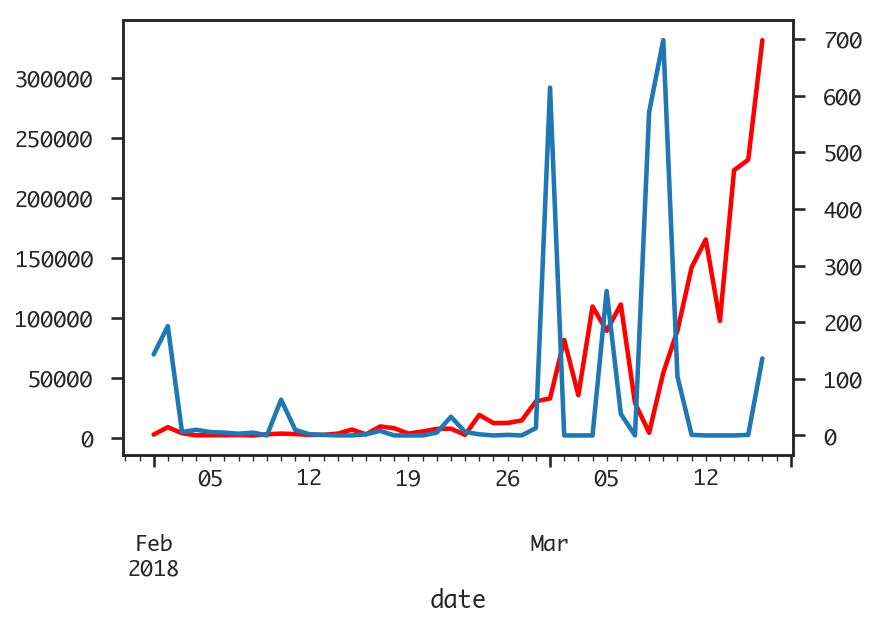

In [8]:
ax = df['花粉飛散数[個/m3]'].resample('D').sum().plot(color='red')
ax2=ax.twinx()
df['レーダー降水量[mm]'].resample('D').sum().plot(ax=ax2)

3/8付近が少ない。降水量に関係あるようなないような。

In [9]:
df.corr()

,測定局種別,花粉飛散数[個/m3],風向,風速[m/s],気温[℃],降水量[mm],レーダー降水量[mm]
測定局種別,1.000000,0.106094,-0.028109,-0.086691,-0.067311,0.005256,0.002357
花粉飛散数[個/m3],0.106094,1.000000,-0.019395,-0.030712,0.168978,-0.003546,-0.032651
風向,-0.028109,-0.019395,1.000000,0.054336,-0.120947,0.007044,0.020690
風速[m/s],-0.086691,-0.030712,0.054336,1.000000,0.362476,0.010181,0.077645
気温[℃],-0.067311,0.168978,-0.120947,0.362476,1.000000,0.004899,0.091325
降水量[mm],0.005256,-0.003546,0.007044,0.010181,0.004899,1.000000,0.104127
レーダー降水量[mm],0.002357,-0.032651,0.020690,0.077645,0.091325,0.104127,1.000000


* 単純に同じ時間帯のデータでは高い相関がなさそう

In [10]:
tdf = df.loc[:,['花粉飛散数[個/m3]','気温[℃]','降水量[mm]','レーダー降水量[mm]']]
size=24
tdf['花粉MA'] = tdf['花粉飛散数[個/m3]'].rolling(size).mean()
tdf['気温MA'] = tdf['気温[℃]'].rolling(size).mean()
tdf['降水量MA'] = tdf['降水量[mm]'].rolling(size).mean()
tdf['レーダー降水量MA'] = tdf['レーダー降水量[mm]'].rolling(size).mean()
tdf.corr()

,花粉飛散数[個/m3],気温[℃],降水量[mm],レーダー降水量[mm],花粉MA,気温MA,降水量MA,レーダー降水量MA
花粉飛散数[個/m3],1.000000,0.168978,-0.003546,-0.032651,0.585834,0.256631,-0.003406,0.004143
気温[℃],0.168978,1.000000,0.004899,0.091325,0.213028,0.694040,0.018003,0.185535
降水量[mm],-0.003546,0.004899,1.000000,0.104127,-0.006586,-0.001272,0.208166,0.059891
レーダー降水量[mm],-0.032651,0.091325,0.104127,1.000000,-0.033066,0.091528,0.116679,0.414101
花粉MA,0.585834,0.213028,-0.006586,-0.033066,1.000000,0.342311,-0.025526,-0.043723
気温MA,0.256631,0.694040,-0.001272,0.091528,0.342311,1.000000,0.022208,0.239742
降水量MA,-0.003406,0.018003,0.208166,0.116679,-0.025526,0.022208,1.000000,0.333685
レーダー降水量MA,0.004143,0.185535,0.059891,0.414101,-0.043723,0.239742,0.333685,1.000000


## Window Function

* rolling window
* expanding window

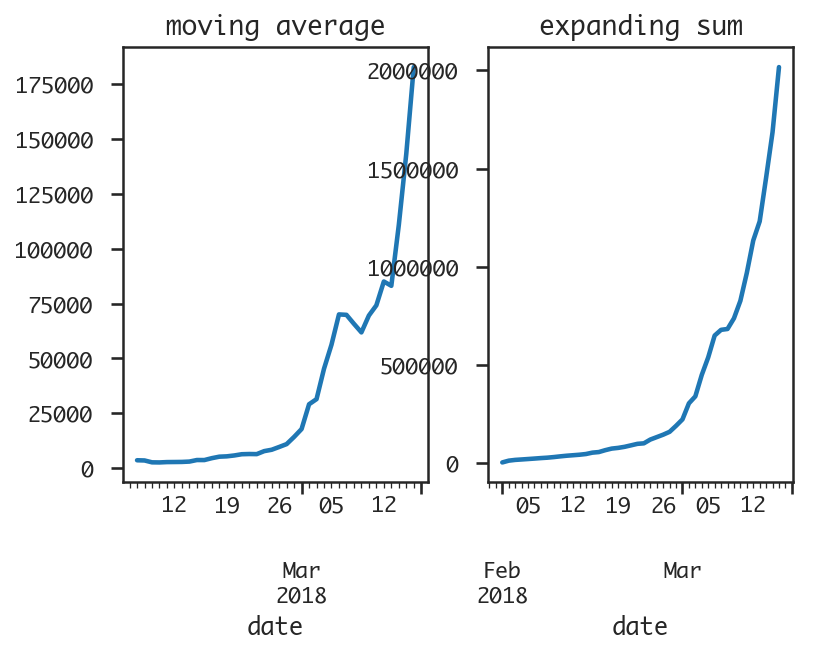

In [11]:
s = df['花粉飛散数[個/m3]'].resample('D').sum()
fig, ax = plt.subplots(1,2)
s.rolling(7).mean().plot(ax=ax[0],title='moving average')
s.expanding().sum().plot(ax=ax[1],title='expanding sum')

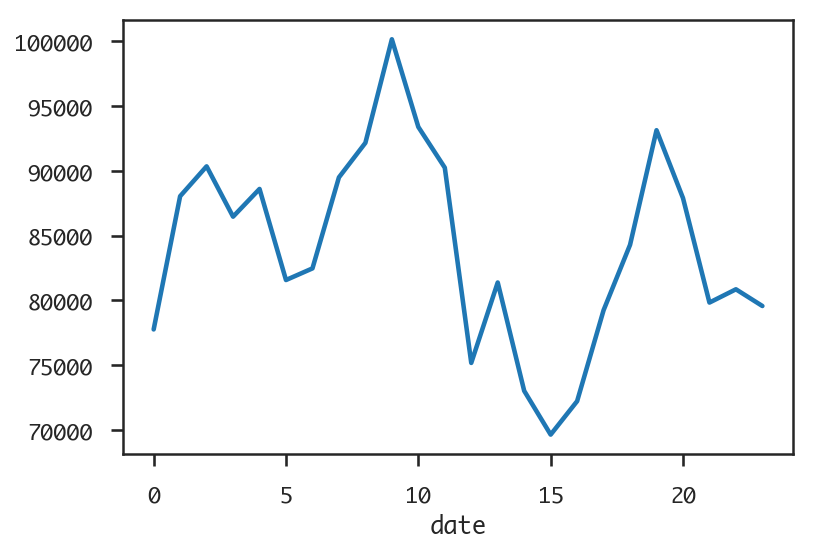

In [12]:
df['花粉飛散数[個/m3]'].groupby(df.index.hour).sum().plot()

時間別で見るとなんと15時が一番少ない。。。

# 気温のデータ

In [13]:
tdf = pd.DataFrame()
for f in glob.glob("data/temp_*.csv"):
    tdf = tdf.append(pd.read_csv(f, skiprows=[0,1,3,4,5], usecols=[0,1], index_col=0, parse_dates=[0]))

In [14]:
tdf.head()

,千葉
2018-01-01 01:00:00,0.5
2018-01-01 02:00:00,0.6
2018-01-01 03:00:00,0.4
2018-01-01 04:00:00,1.0
2018-01-01 05:00:00,0.6


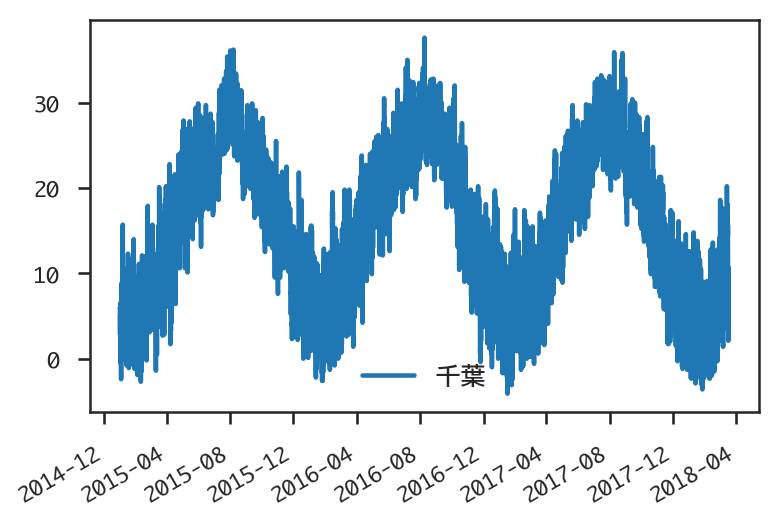

In [15]:
tdf.plot()

## Autocorrelation

* Autocorrelation
  * 前の観測点との差分。日データなら1が1日前。7が1週前。365が1年前。
* Partial Autocorrelation
  * Autocorrelationのうち、一番小さい差分のものが残るようにしたもの。
  * 例えば7日周期性のあるデータなら7に基づく14,21,...は高くならないように調整される。(本当の14日周期が残る)

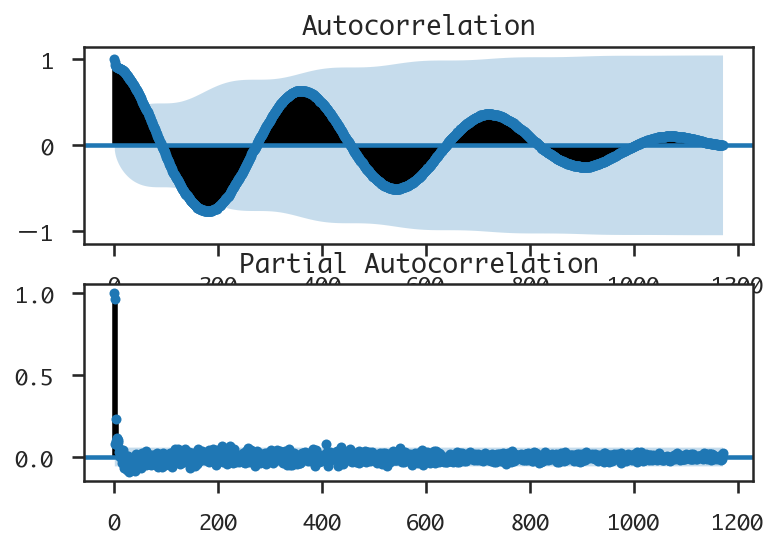

In [16]:
s = tdf.resample('D').mean()
fig, ax = plt.subplots(2,1)
fig = sm.tsa.graphics.plot_acf(s, ax=ax[0])
fig = sm.tsa.graphics.plot_pacf(s, ax=ax[1])

# seasonal decompose

In [17]:
air_passengers = pd.read_csv("data/AirPassengers.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0)

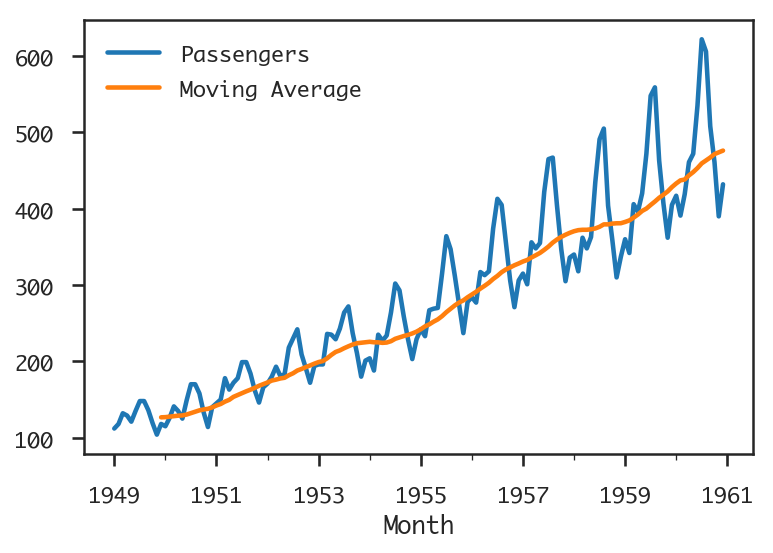

In [18]:
air_passengers['Moving Average'] = air_passengers.rolling(12).mean()
air_passengers.plot()

## AR + MA

In [19]:
def ar1(phi = .9, n = 100, init = 0):
    time_series = [init]
    error = np.random.randn(n)
    for period in range(n):
        time_series.append(error[period] + phi*time_series[-1])
    return pd.Series(time_series[1:], index = range(n))

In [20]:
def ma1(theta = .5, n = 100):
    time_series = []
    error = np.random.randn(n)
    for period in range(1,n):
        time_series.append(error[period] + theta*error[period-1])
    return pd.Series(time_series[1:], index = range(1,n-1))

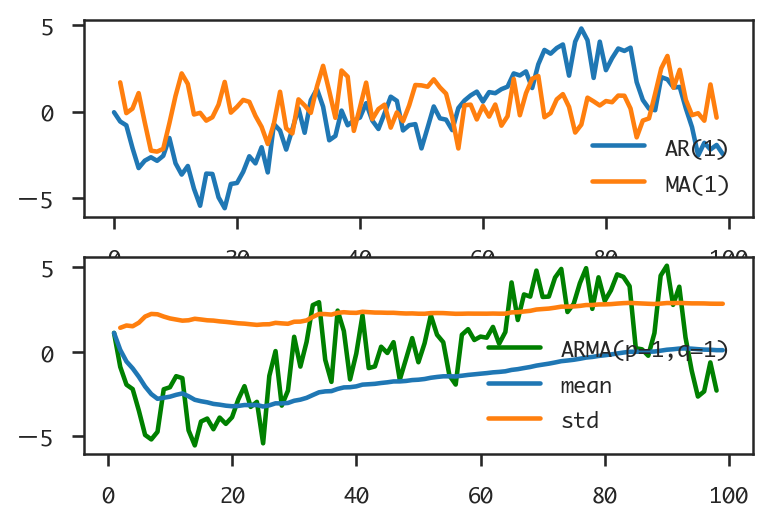

In [21]:
s1 = ar1(n=100)
s2 = ma1(n=100)
s3 = s1+s2
plt.subplot(211)
s1.plot(label='AR(1)')
s2.plot(label='MA(1)')
plt.legend()
plt.subplot(212)
s3.plot(label='ARMA(p=1,q=1)',color='green')
s3.expanding().mean().plot(label='mean')
s3.expanding().std().plot(label='std')
plt.legend()

* ARMAで表す = 定常(stationary)でないと表せない
  * 平均、標準偏差が一定

# ARIMA

* AR + MA + I (=differencing)
* 差分をとってトレンドをなくす(定常にしたい)

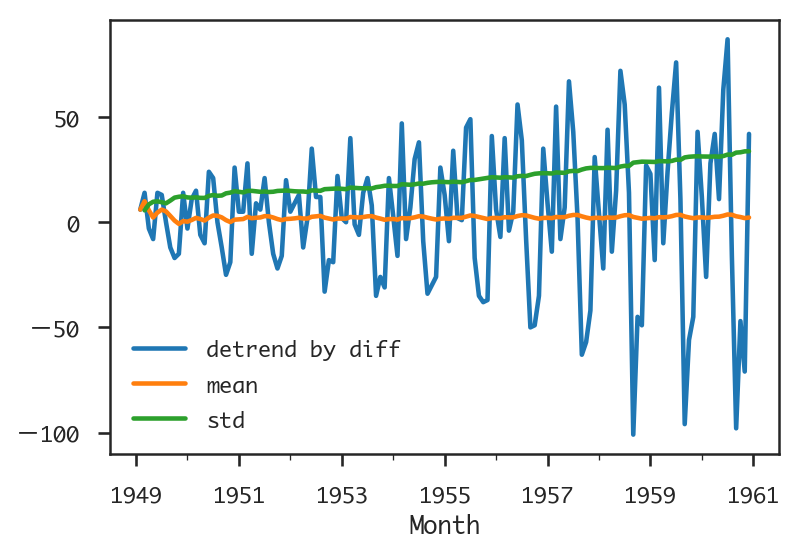

In [22]:
diff = air_passengers['Passengers'].diff()
diff.plot(label='detrend by diff')
diff.expanding().mean().plot(label='mean')
diff.expanding().std().plot(label='std')
plt.legend()

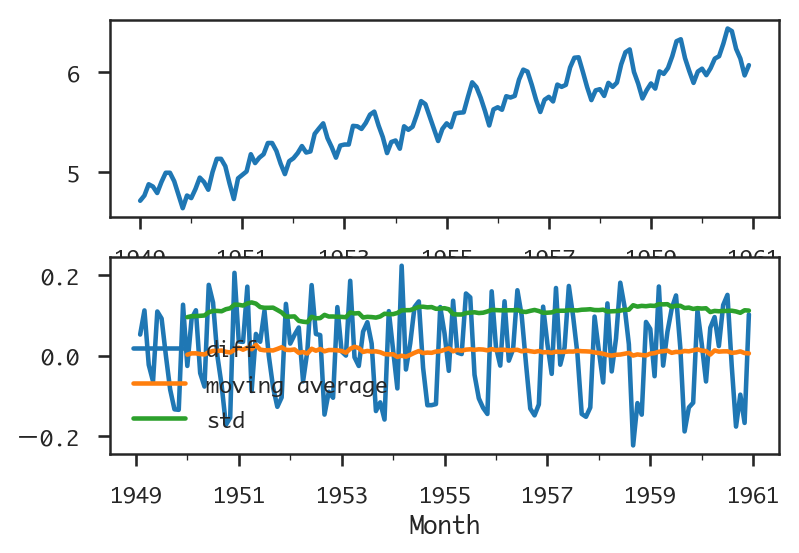

In [23]:
fig,ax = plt.subplots(2,1)
log = np.log(air_passengers['Passengers'])
log.plot(label='log', ax=ax[0])
log.diff().plot(label='diff', ax=ax[1])
log.diff().rolling(12).mean().plot(label='moving average', ax=ax[1])
log.diff().rolling(12).std().plot(label='std', ax=ax[1])
plt.legend()

In [24]:
arima = sm.tsa.SARIMAX(log, order=(1,1,1)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  144
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 124.313
Date:                Mon, 26 Mar 2018   AIC                           -242.626
Time:                        23:01:44   BIC                           -233.717
Sample:                    01-01-1949   HQIC                          -239.006
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5773      0.164     -3.516      0.000      -0.899      -0.256
ma.L1          0.8478      0.098      8.686      0.000       0.657       1.039
sigma2         0.0103      0.002      5.992      0.000       0.007       0.014
===================================================================================
Ljung-Box (Q):                      354.63   Jarque-Bera (JB):                 5.94
Prob(Q):                              0.00   Prob(JB):                         0.05
Heteroskedasticity (H):               1.07   Skew:                             0.04
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

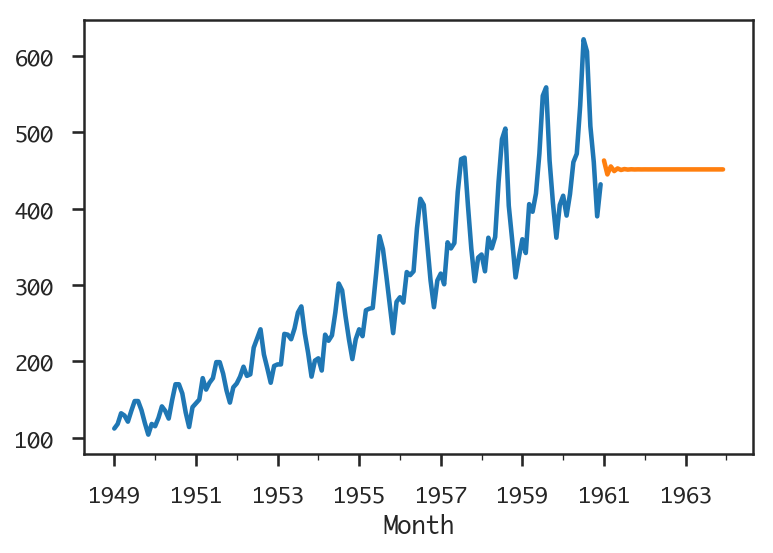

In [25]:
ax = np.exp(log).plot()
np.exp(arima.forecast(36, ax=ax)).plot()

In [26]:
sarima = sm.tsa.SARIMAX(log, order=(1,1,1), trend='c', seasonal_order=(1,1,1,12)).fit()
sarima.summary()

/Users/keiji/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 245.173
Date:                            Mon, 26 Mar 2018   AIC                           -478.345
Time:                                    23:01:47   BIC                           -460.527
Sample:                                01-01-1949   HQIC                          -471.105
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.001     -0.196      0.844      -0.002       0.001
ar.L1          0.1721      0.213      0.809      0.418      -0.245       0.589
ma.L1         -0.5666      0.185     -3.066      0.002      -0.929      -0.204
ar.S.L12      -0.0982      0.202     -0.486      0.627      -0.494       0.298
ma.S.L12      -0.4993      0.218     -2.286      0.022      -0.927      -0.071
sigma2         0.0013      0.000      8.467      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       37.14   Jarque-Bera (JB):                 3.54
Prob(Q):                              0.60   Prob(JB):                         0.17
Heteroskedasticity (H):               0.61   Skew:                            -0.02
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

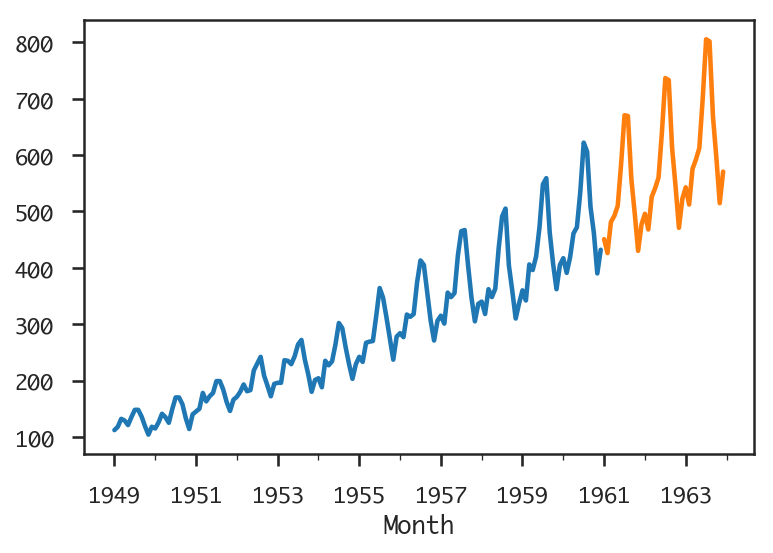

In [27]:
ax = np.exp(log).plot()
np.exp(sarima.forecast(36, ax=ax)).plot()